### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from pylab import rcParams
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 

In [5]:
import pandas as pd
data=pd.read_csv("Data_Xgboost.txt",sep=",")
data.head()
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500
2010,2019-12-30,289.459991,292.690002,285.220001,291.519989,289.522614,36028600


As disucussed, we need only "Date" and "Adj Close" data for our analysis hence we will proceed to drop the rest of the columns. 

data= data.drop(axis=1,labels=['Unnamed: 0','Open','High','Low','Close','Volume'])

# **Feature Selection**
We can eliminate features like Open,Low, High Close automatically as they are high multicollinear with Adj Close .

We consider Adj Close as our target variables as it accounts for all corporate decisions .

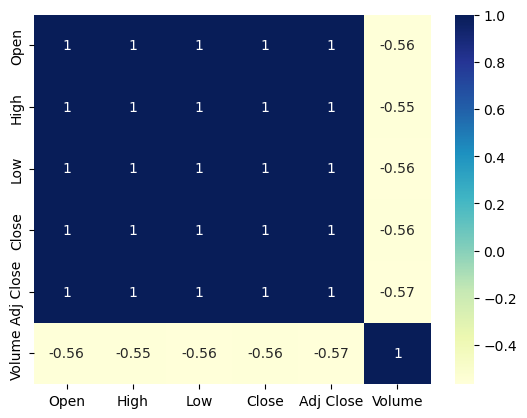

In [6]:
corrM=data.corr()
dataplot = sns.heatmap(corrM, cmap="YlGnBu", annot=True)

In [7]:
data= data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

In [8]:
data.head()

,Date,Adj Close
0,2012-01-03,50.765709
1,2012-01-04,51.038536
2,2012-01-05,51.605175
3,2012-01-06,52.144630
4,2012-01-09,52.061932


Now, we can go for checking the null values in our data set.

In [9]:
data.isnull().sum()

Date         0
Adj Close    0
dtype: int64

There are no null values here. We can proceed further.

We will set "Date" as the data index

In [10]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

In [11]:
data=data.set_index('Date')

In [12]:
data.head()

,Adj Close
Date,
2012-01-03,50.765709
2012-01-04,51.038536
2012-01-05,51.605175
2012-01-06,52.144630
2012-01-09,52.061932


Now, we shall convert our daily data to monthly data.

In [13]:
monthly_mean = data['Adj Close'].resample('M').mean()

In [14]:
monthly_data = monthly_mean.to_frame()

In [15]:
monthly_data.head()

,Adj Close
Date,
2012-01-31,52.907298
2012-02-29,61.424381
2012-03-31,71.292448
2012-04-30,74.810151
2012-05-31,69.708045


<AxesSubplot:xlabel='Date'>

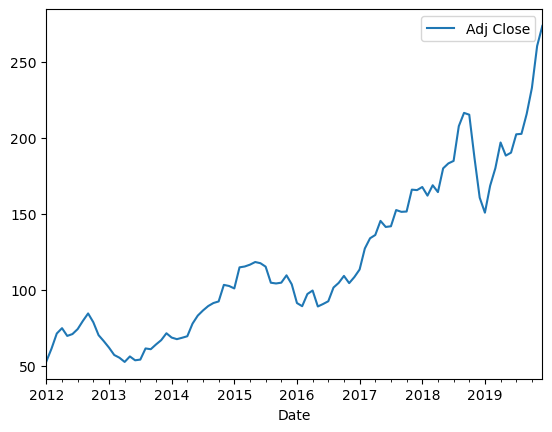

In [16]:
monthly_data.plot()

### Outlier Detection

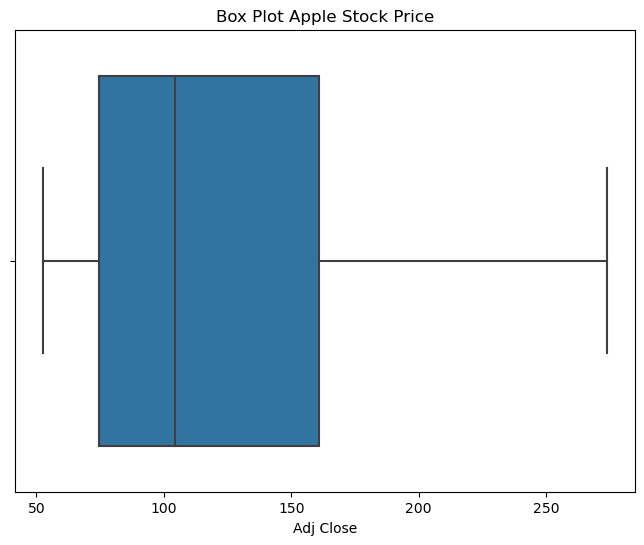

In [17]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(monthly_data['Adj Close']).set_title('Box Plot Apple Stock Price')
plt.style.context('fivethirtyeight')

Middle line is the median.The data is clearly right skwed. Also, We have no outliers

In [18]:
monthly_data.describe()

,Adj Close
count,96.000000
mean,119.419554
std,52.573897
min,52.584215
25%,74.657848
50%,104.544474
75%,161.059315
max,273.780717


Time-Series Decomposition

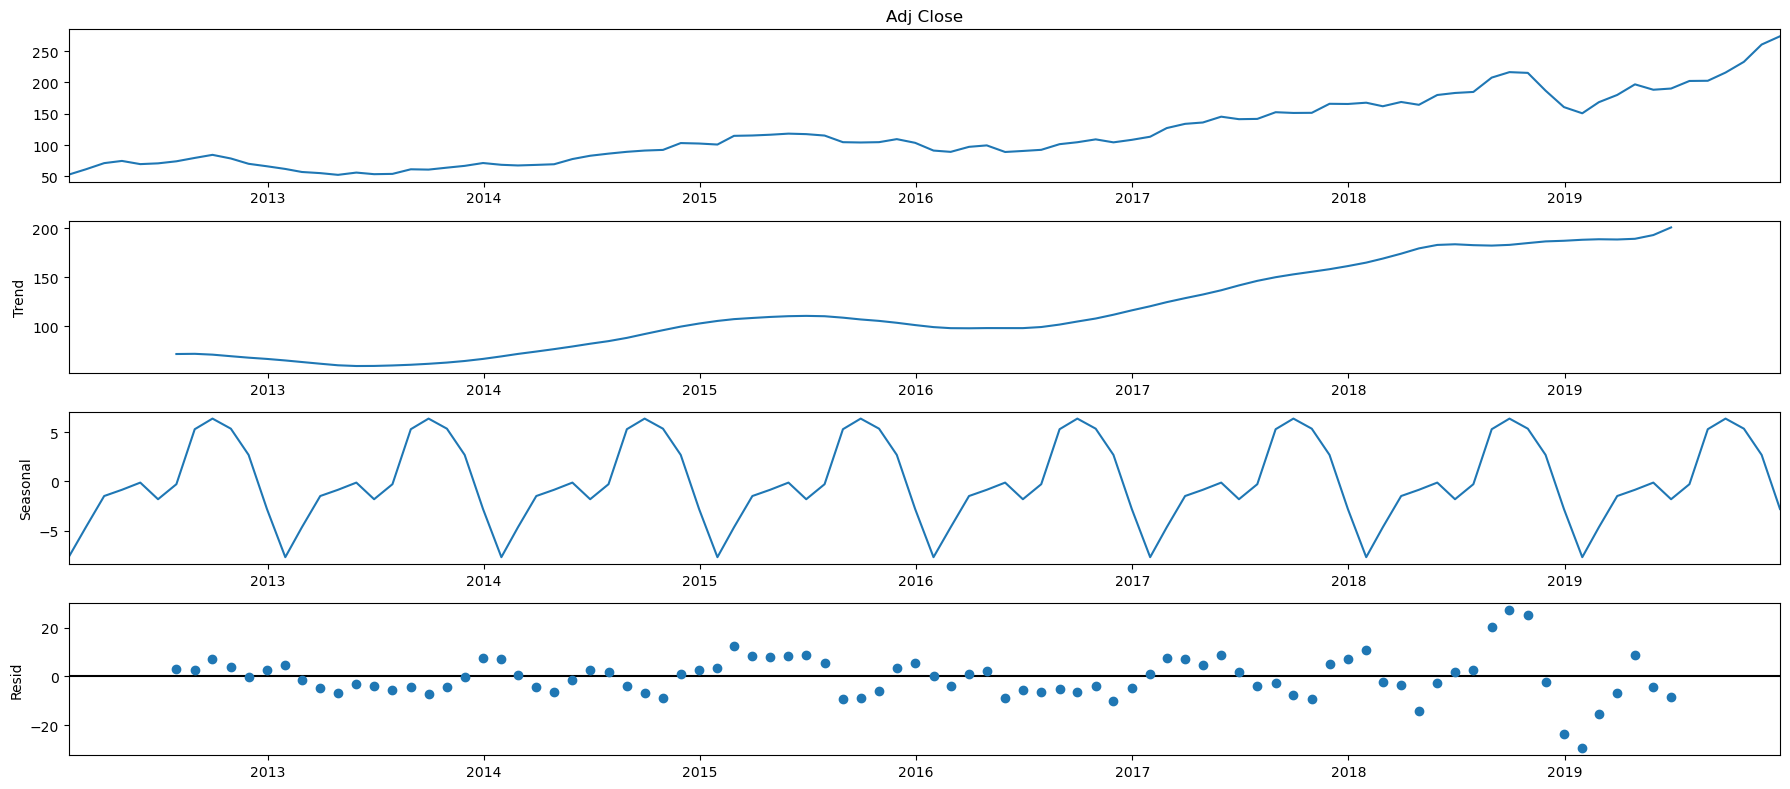

In [19]:
rcParams['figure.figsize'] = 18, 8
#plt.figure(figsize=(25,16))
 0.
    

### Test for Stationarity

Using Augmented Dickey-Fuller(ADF) Test

Null Hypothesis : Time series is non-stationary

Alternate Hypothesis : Time series is stationary

Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.


In [20]:
from statsmodels.tsa.stattools import adfuller 
def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
      print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')


### Transforming data into stationary data

#### Differencing

In [21]:
#Differencing by 1
monthly_data["lag1"] = monthly_data['Adj Close'].diff()
#monthly_data=monthly_data.dropna(axis=0)
monthly_data.head()

,Adj Close,lag1
Date,,
2012-01-31,52.907298,NaN
2012-02-29,61.424381,8.517082
2012-03-31,71.292448,9.868067
2012-04-30,74.810151,3.517702
2012-05-31,69.708045,-5.102106


In [22]:
ad_fuller_func(monthly_data["lag1"].dropna())

ADF Statistic: -6.501865
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Reject Null Hypothesis(Ho)-Time Series is Stationary


<AxesSubplot:xlabel='Date'>

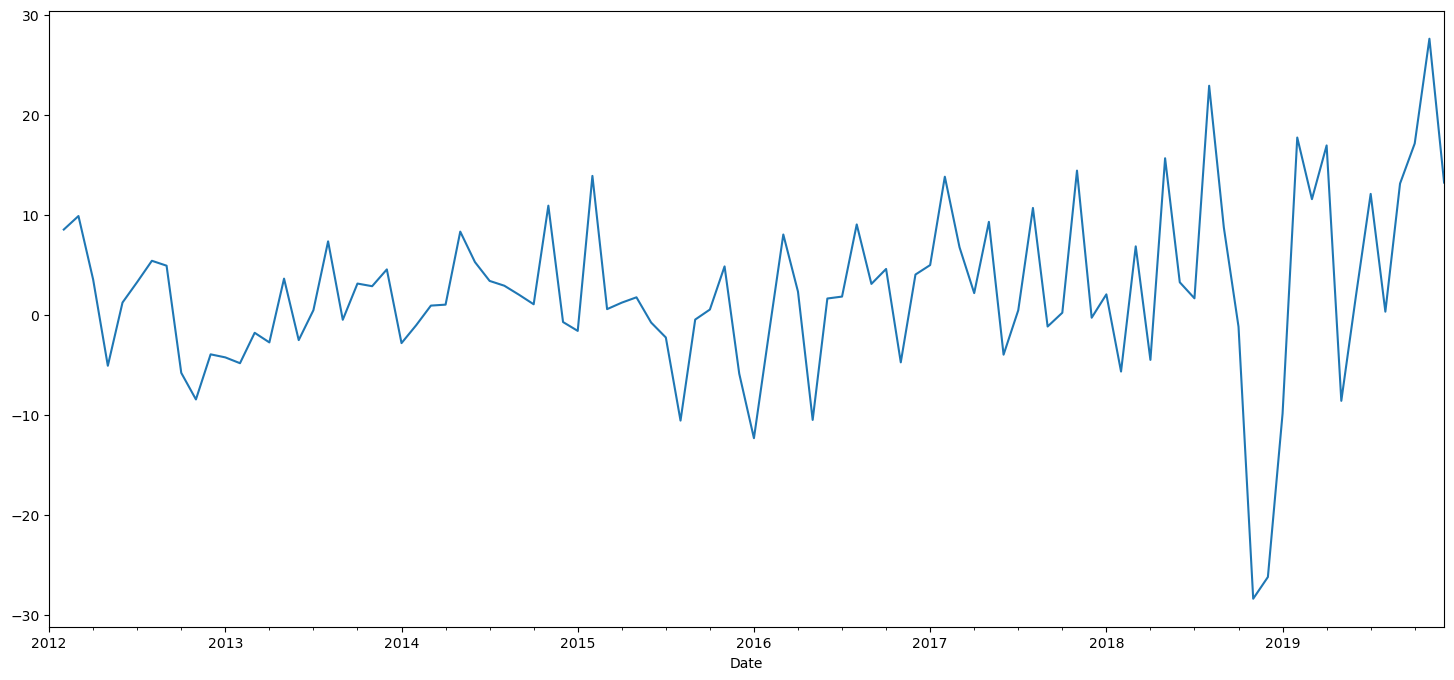

In [23]:
monthly_data['lag1'].plot()

### Long-range and Short-range ACF plots

Text(0.5, 0, 'Lags')

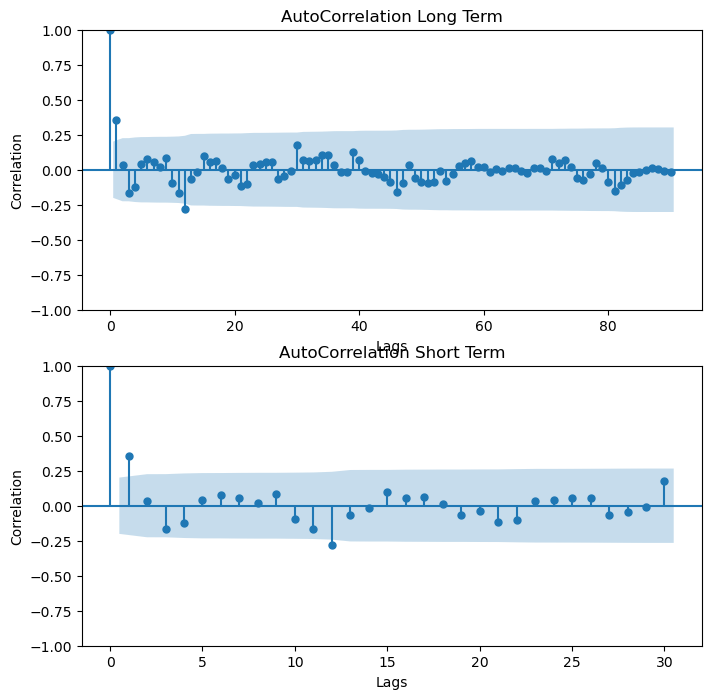

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig,(ax1,ax2) = plt.subplots(2,figsize=(8,8))
acf = plot_acf(monthly_data['lag1'].dropna(),lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['lag1'].dropna(),lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

### Long-range and Short-range PACF plots

Text(0.5, 0, 'Lags')

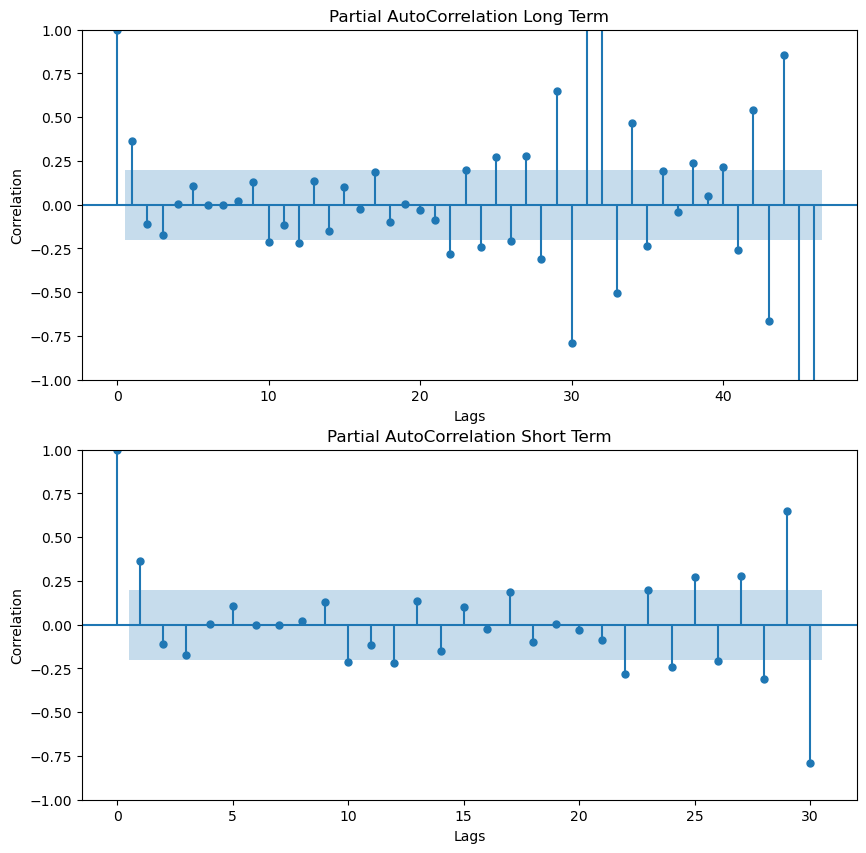

In [25]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
pacf = plot_pacf(monthly_data['lag1'].dropna(),lags=46,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['lag1'].dropna(),lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

Conclusion: We can use SARIMA for this data.

In [26]:
modelling_series = monthly_data['Adj Close']

In [27]:
modelling_series

Date
2012-01-31     52.907298
2012-02-29     61.424381
2012-03-31     71.292448
2012-04-30     74.810151
2012-05-31     69.708045
                 ...    
2019-08-31    202.738817
2019-09-30    215.853332
2019-10-31    232.974974
2019-11-30    260.569057
2019-12-31    273.780717
Freq: M, Name: Adj Close, Length: 96, dtype: float64

### Train and test data

In [28]:
from sklearn.model_selection import train_test_split as split
train,test = split(modelling_series,train_size=0.6,shuffle=False)#shuffle used not split data in randomly

In [29]:
P = D=Q = range(0, 3)
p=d=q=range(1,2)
# q=range(8,9)
# Q= range(0, 9)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (1, 1, 1) x (0, 0, 1, 12)


### Setting up parameter iterator for Seasonal part

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
list_param = []
list_param_seasonal=[]
list_results_aic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic) #Minimum AIC value gives the model better result
        except:
            continue


SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:326.92357257391876
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:261.7242300231428
SARIMA(1, 1, 1)x(0, 0, 2, 12)12 - AIC:197.2402108271994
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:289.975427769718
SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1323.729019317282
SARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:130.4932163776841
SARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:235.03016898621848
SARIMA(1, 1, 1)x(0, 2, 1, 12)12 - AIC:143.8548207436844
SARIMA(1, 1, 1)x(0, 2, 2, 12)12 - AIC:54.77138399112383
SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:266.840977398283
SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:263.5720650663527
SARIMA(1, 1, 1)x(1, 0, 2, 12)12 - AIC:199.23952246017888
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:213.96607165593167
SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1287.3886030224917
SARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:128.63126242083536
SARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:152.03126291899304
SARIMA(1, 1, 1)x(1, 2, 1, 12)12 - AIC:144.0040188040459
SARIMA(1, 1, 1)x(1, 2, 2, 12)12 - AIC:57.27

In [31]:
sorted(list_results_aic)

[54.77138399112383,
 57.277027259629584,
 59.6326239570125,
 63.144818797091304,
 65.00305958928013,
 122.91494687745298,
 128.63126242083536,
 130.4932163776841,
 133.72937687046738,
 143.8548207436844,
 144.0040188040459,
 152.03126291899304,
 193.49436439027195,
 197.2402108271994,
 199.23952246017888,
 200.3179604454417,
 202.2540176730417,
 213.96607165593167,
 235.03016898621848,
 261.7242300231428,
 263.5720650663527,
 266.840977398283,
 289.975427769718,
 326.92357257391876,
 825.0750087357072,
 1287.3886030224917,
 1323.729019317282]

|params|AIC|
|--|--|
|SARIMA(1, 1, 1)x(0, 2, 2, 12)12| AIC:54.7713839911655|
|--|--|
|SARIMA(1, 1, 1)x(1, 2, 2, 12)12|AIC:57.2770266539175|
|--|--|
|SARIMA(1, 1, 1)x(2, 2, 2, 12)12|AIC:59.63262395786524|
|---|---|
|SARIMA(1, 1, 1)x(2, 2, 0, 12)12|AIC:63.14481879709777|
|---|---|
|SARIMA(1, 1, 1)x(2, 2, 1, 12)12 |AIC:65.00422608218713|

In [32]:
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

### Model 1

In [33]:
model1 = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(1, 2, 2, 12))
results=model1.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

print(result_metrics(train,forecasts_train,'SARIMA-Train Data: Model 1'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data: Model 1'))

Result Metrics for SARIMA-Train Data: Model 1
R2 Score :  0.49
Mean Squared Error :  199.795
Mean Absolute Error :  9.806
None
----
Result Metrics for SARIMA-Test Data: Model 1
R2 Score :  -0.046
Mean Squared Error :  1556.528
Mean Absolute Error :  34.805
None


### Model 2

In [34]:
model2 = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(0, 2, 2, 12))
results=model2.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

print(result_metrics(train,forecasts_train,'SARIMA-Train Data:Model 2'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data: Model 2'))

Result Metrics for SARIMA-Train Data:Model 2
R2 Score :  0.49
Mean Squared Error :  200.129
Mean Absolute Error :  9.803
None
----
Result Metrics for SARIMA-Test Data: Model 2
R2 Score :  -1.121
Mean Squared Error :  3157.535
Mean Absolute Error :  49.803
None


### Model 3

In [35]:
model3 = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2, 2, 2, 12))
results=model3.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

print(result_metrics(train,forecasts_train,'SARIMA-Train Data:Model 3'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data: Model 3'))

Result Metrics for SARIMA-Train Data:Model 3
R2 Score :  0.492
Mean Squared Error :  199.103
Mean Absolute Error :  9.791
None
----
Result Metrics for SARIMA-Test Data: Model 3
R2 Score :  0.456
Mean Squared Error :  809.92
Mean Absolute Error :  21.977
None


### Model 4

In [36]:
model4 = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2, 2, 0, 12))
results=model4.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

print(result_metrics(train,forecasts_train,'SARIMA-Train Data:Model 4'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data: Model 4'))

Result Metrics for SARIMA-Train Data:Model 4
R2 Score :  0.491
Mean Squared Error :  199.567
Mean Absolute Error :  9.797
None
----
Result Metrics for SARIMA-Test Data: Model 4
R2 Score :  0.704
Mean Squared Error :  441.122
Mean Absolute Error :  17.557
None


### Model 5

In [37]:
model5 = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2, 2, 1, 12))
results=model5.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

print(result_metrics(train,forecasts_train,'SARIMA-Train Data:Model 5'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data: Model 5'))

Result Metrics for SARIMA-Train Data:Model 5
R2 Score :  0.492
Mean Squared Error :  199.288
Mean Absolute Error :  9.796
None
----
Result Metrics for SARIMA-Test Data: Model 5
R2 Score :  0.6
Mean Squared Error :  595.587
Mean Absolute Error :  19.68
None


We shall choose the set of parameters that minimizes AIC. A lower AIC score implies a better goodness-of-fit i.e a balance between over-fitting and under-fitting

By Observing among the Lowest AIC values and Mean squared errors , we come to Seasonality Order of (2,2,0)12 and non-seasonal component is (1,1,1) as derived earlier by correlograms.

### Forecasting with SARIMA

In [38]:
model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2, 2, 0, 12))
results=model.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')



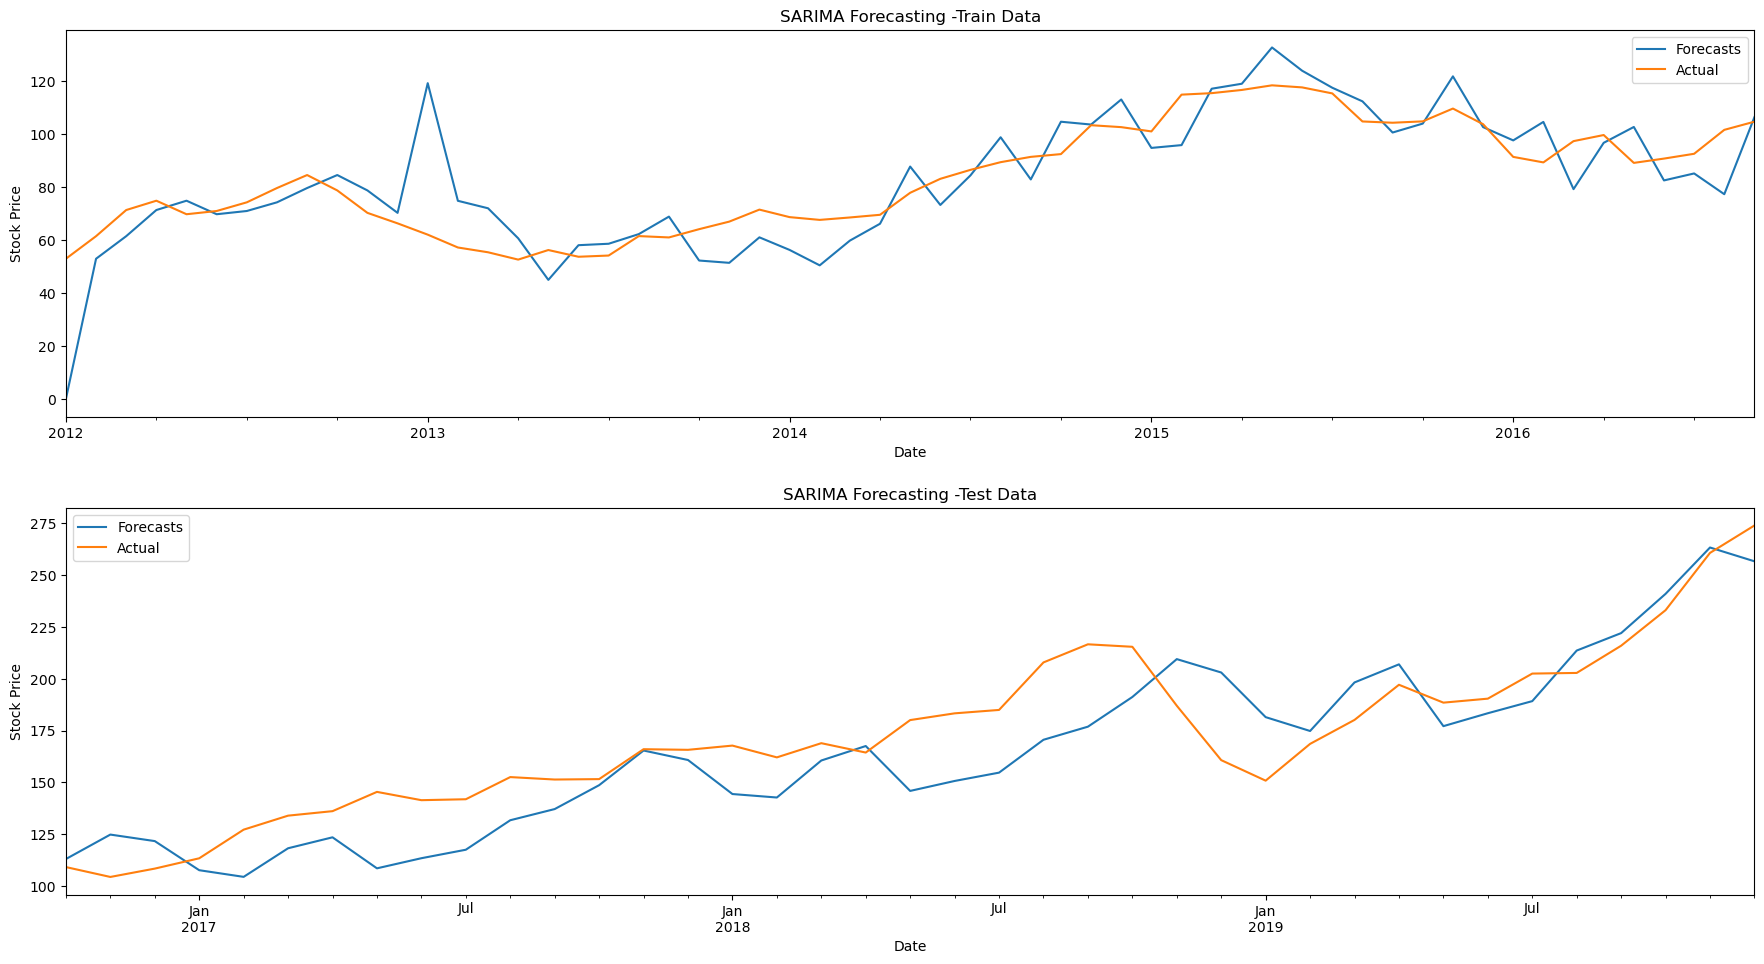

In [39]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [40]:
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

In [41]:
print(result_metrics(train,forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.491
Mean Squared Error :  199.567
Mean Absolute Error :  9.797
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.704
Mean Squared Error :  441.122
Mean Absolute Error :  17.557
None


###  symmetric mean absolute percentage error

In [42]:
import pandas as pd
import numpy as np

# Define the function to return the SMAPE value
def calculate_smape(actual, predicted) -> float:

	# Convert actual and predicted to numpy
	# array data type if not already
	if not all([isinstance(actual, np.ndarray),
				isinstance(predicted, np.ndarray)]):
		actual, predicted = np.array(actual),np.array(predicted)

	return round(
		np.mean(
			np.abs(predicted - actual) /
			((np.abs(predicted) + np.abs(actual))/2)
		)*100, 2
	)




In [43]:
calculate_smape(train,forecasts_train)

14.77

In [44]:
calculate_smape(test,forecasts_test)

11.04